***...THIS IS A DEFINETLY A NOTEBOOK...***

*Check and update 'init.py' script with dataset specific informations. It functions as a main dictionary for all the scripts.*

*Open the script in a text editor to read more.*

**Load the main dictionary**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import mne
import matplotlib.gridspec as gridspec
from teaspoon.TDA.SLSP import Persistence0D
from teaspoon.TDA.SLSP_tools import cutoff

path = '/home/lunis/Documents/nlin-EEG/evoked/avg/BMD/001'

evokeds = mne.read_evokeds(path + '-ave.fif', verbose = False)
e_evokeds = mne.read_evokeds(path + '_std-ave.fif', verbose = False)

t = evokeds[6].times

ts_0 = evokeds[6].get_data(picks = 'Oz')

std_ts_0 = e_evokeds[6].get_data(picks = 'Oz')#*np.sqrt(e_evokeds[0].nave)

#----------------Assume the additive noise distribution---------------
dist = 'Gaussian'

#---------------Generate a time series with additive noise------------
fs, T = 1000, t[-1]
ts = ts_0#np.random.normal(ts_0,std_ts_0) #gaussian distribution additive noise
ts = ts[0]

#--------------Run sublevel set persistence--------------------------
feature_ind_1, feature_ind_2, persistenceDgm = Persistence0D(ts)
B = np.flip(persistenceDgm.T[0], axis = 0) #get birth times
D = np.flip(persistenceDgm.T[1], axis = 0) #get death times
L = D-B #get lifetimes as difference between birth and death

I_B = np.array(feature_ind_1.astype(int)).T #indices of birth times
T_B = np.flip(t[I_B], axis = 0) #time values at birth times

#-------------get cutoff for persistence diagram---------------------
C, param = cutoff(L, alpha = 0.01, n = len(ts), distribution = dist) #get cutoff
print('Distribution parameter estimate: ', param)
print('C: ', C)


#-------------------------PLOTTING THE RESULTS-----------------------
gs = gridspec.GridSpec(2,3)
plt.figure(figsize=(17,5))
TextSize = 15

ax = plt.subplot(gs[0, 0:2])
plt.plot(t,ts, 'k')
plt.ylabel('$x(t)$', size = TextSize)
plt.xticks(size = TextSize)
plt.yticks(size = TextSize)
plt.xlim(min(t),max(t))

ax = plt.subplot(gs[1, 0:2])
plt.ylabel('$L$', size = TextSize)
plt.xlabel('$t$', size = TextSize)
plt.xticks(size = TextSize)
plt.yticks(size = TextSize)
plt.plot(T_B[L>C], L[L>C], 'bd', label = r'$L$ (signal)')
plt.plot(T_B[L<C], L[L<C], 'ko', alpha = 0.7, label = r'$L$ (noise)')
plt.plot([np.min(t),np.max(t)],[C, C],'k--', label = r'$C^*_\alpha$')
ax.fill_between([min(t), max(t)], [C, C], color = 'red', alpha = 0.15)
plt.ylim(0,)
plt.xlim(min(t),max(t))
plt.legend(loc = 'right', fontsize = TextSize-3, ncol = 2)

ax = plt.subplot(gs[0:2, 2])
plt.ylabel('$D$', size = TextSize)
plt.xlabel('$B$', size = TextSize)
plt.xticks(size = TextSize)
plt.yticks(size = TextSize)
plt.plot(B[L>C], D[L>C], 'bd', label = r'signal')
plt.plot(B[L<C], D[L<C], 'ro', alpha = 0.7, label = r'noise')
plt.plot([min(B), max(D)], [min(B), max(D)],'k')
plt.plot([min(B), max(D)], [min(B)+C, max(D)+C],'k--', label = r'$C_\alpha$')
ax.fill_between(x = [min(B), max(D)], y1 = [min(B)+C, max(D)+C], y2 = [min(B), max(D)],
                                 color = 'red', alpha = 0.15)
plt.legend(loc = 'lower right', fontsize = TextSize-3, bbox_to_anchor = (1.02, -0.02))

plt.subplots_adjust(wspace=0.3)
plt.show()

print(len(feature_ind_1))
print(len(feature_ind_2))

In [ ]:
#import needed packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx

#teaspoon functions
from teaspoon.SP.network import ordinal_partition_graph
from teaspoon.SP.network_tools import remove_zeros
from teaspoon.SP.network_tools import make_network
from teaspoon.TDA.PHN import DistanceMatrix, point_summaries, PH_network

# Time series data

path = '/home/lunis/Documents/nlin-EEG/evoked/avg/BMD/036'

evokeds = mne.read_evokeds(path + '-ave.fif', verbose = False)
e_evokeds = mne.read_evokeds(path + '_std-ave.fif', verbose = False)

for i in range(0,len(evokeds)):

    t = evokeds[i].times

    ts = evokeds[i].get_data(picks = 'Oz')[0]

    print(ts.shape)

    #std_ts_0 = e_evokeds[i].get_data(picks = 'Oz')#*np.sqrt(e_evokeds[0].nave)

    A = ordinal_partition_graph(ts, n = 5, tau = 35) #adjacency matrix
    A = remove_zeros(A) #remove nodes of unused permutation
    G = nx.from_numpy_array(A)
    G.remove_edges_from(nx.selfloop_edges(G))
    #create distance matrix and calculate persistence diagram
    D = DistanceMatrix(A, method = 'diffusion_distance')
    diagram = PH_network(D)

    print('1-D Persistent Homology (loops): ', diagram[1])

    stats = point_summaries(diagram, A)
    print('Persistent homology of network statistics: ', stats)



    TextSize = 14
    plt.figure(2)
    plt.figure(figsize=(8,8))
    gs = gridspec.GridSpec(4, 2)

    ax = plt.subplot(gs[0:2, 0:2]) #plot time series
    plt.title('Time Series', size = TextSize)
    plt.plot(ts, 'k')
    plt.xticks(size = TextSize)
    plt.yticks(size = TextSize)
    plt.xlabel('$t$', size = TextSize)
    plt.ylabel('$x(t)$', size = TextSize)
    plt.xlim(0,len(ts))

    ax = plt.subplot(gs[2:4, 0])
    plt.title('Network', size = TextSize)
    nx.draw(G, with_labels=False, font_weight='bold', node_color='blue',
        width=1, font_size = 10, node_size = 30)

    ax = plt.subplot(gs[2:4, 1])
    plt.title('Persistence Diagram', size = TextSize)
    MS = 3
    top = max(diagram[1].T[1])
    plt.plot([0,top*1.25],[0,top*1.25],'k--')
    plt.yticks( size = TextSize)
    plt.xticks(size = TextSize)
    plt.xlabel('Birth', size = TextSize)
    plt.ylabel('Death', size = TextSize)
    plt.plot(diagram[1].T[0],diagram[1].T[1] ,'go', markersize = MS+2)
    plt.xlim(0,top*1.25)
    plt.ylim(0,top*1.25)

    plt.subplots_adjust(hspace= 0.8)
    plt.subplots_adjust(wspace= 0.35)
    plt.show()

In [ ]:
from init import get_maind

maind = get_maind(save = True)

**Transform data in evoked format for easier data fetching launching the 'toMNE.py' script in the terminal**

**After data conversion compute observables with following scripts**

*   corrsum.py : Computes Correlation Sum $C_{m}(r)$ for different embedding dimensions $m$ and scales $r$

*   correxp.py : Computes Correlation Exponent $\nu_{m}(r)$ embedding dimensions $m$ and scales $r$ deriving results from $C_{m}(r)$

*   idim.py : Computes Information Dimension $D_{2}(m)$ for different embedding dimensions $m$ (NOT GOOD)

*   llyap.py : Computes Largest Lyapunov Exponent $\lambda(m)$ for different embedding dimensions $m$

**Following observable computation data can be plotted using the following wrapper**

### spectrum.py script parameters ###

{'window': [...],
 'clustered': False,
 'subjects': [...],
 'conditions': [...],
 'pois': [...],
 'freqs': [...],
 'N': 50,
 'window_factor': 3}



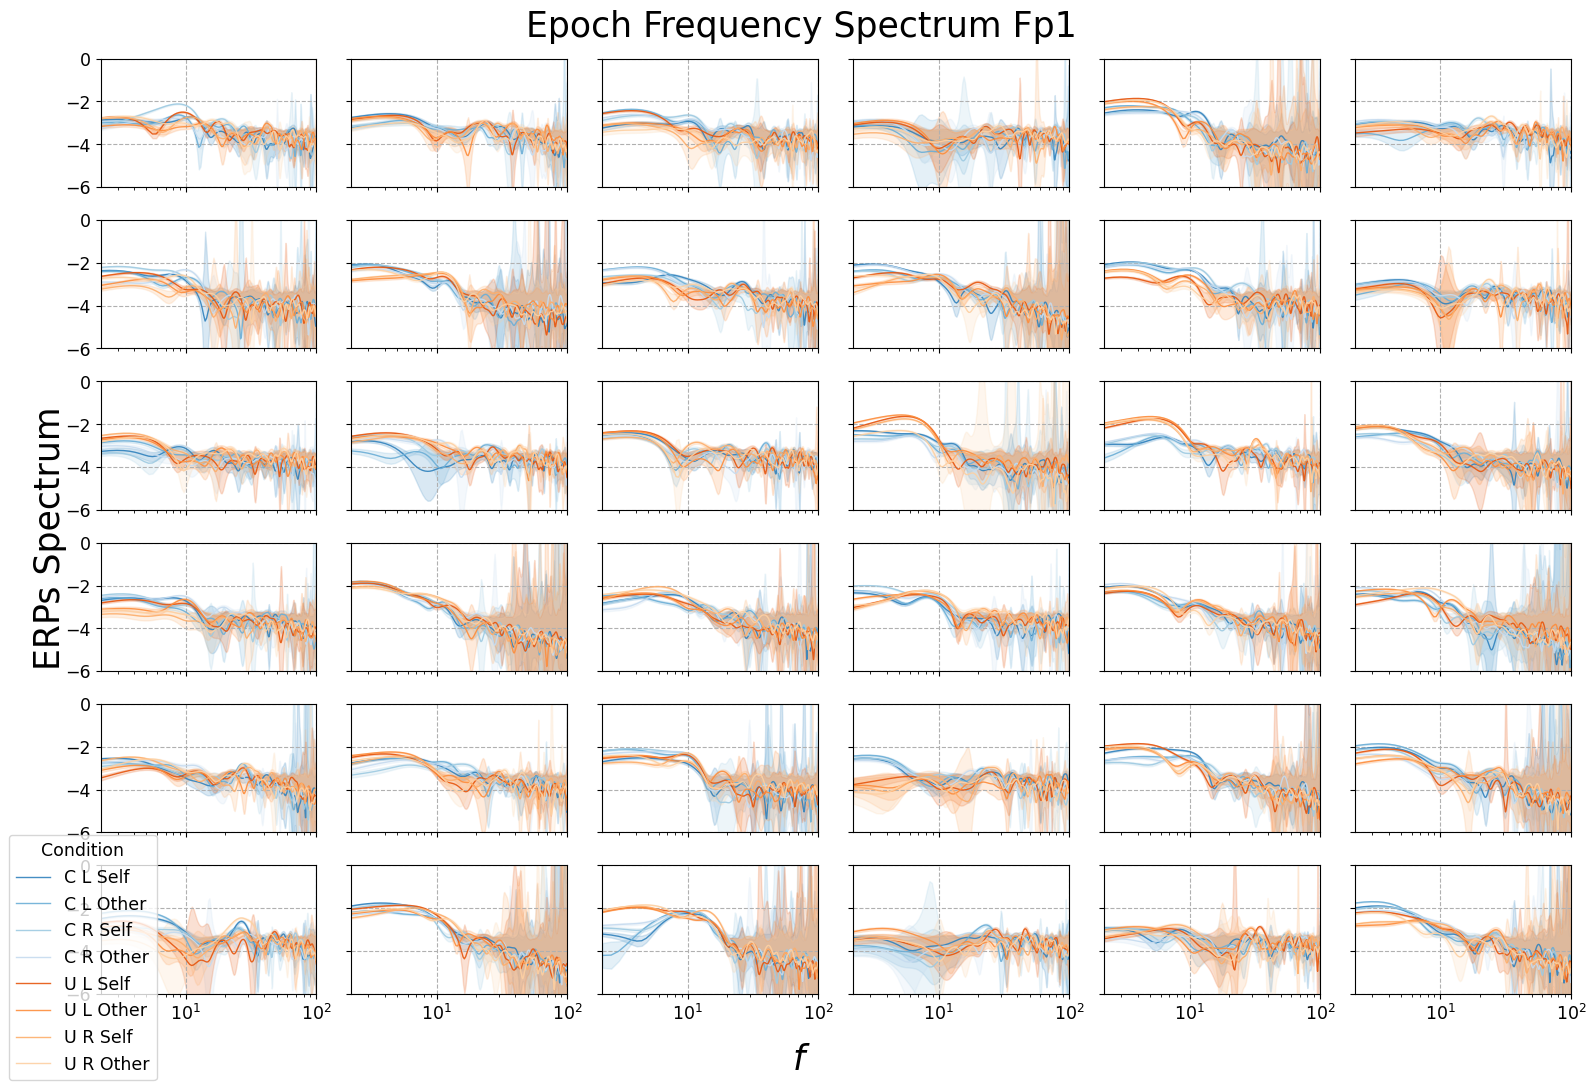

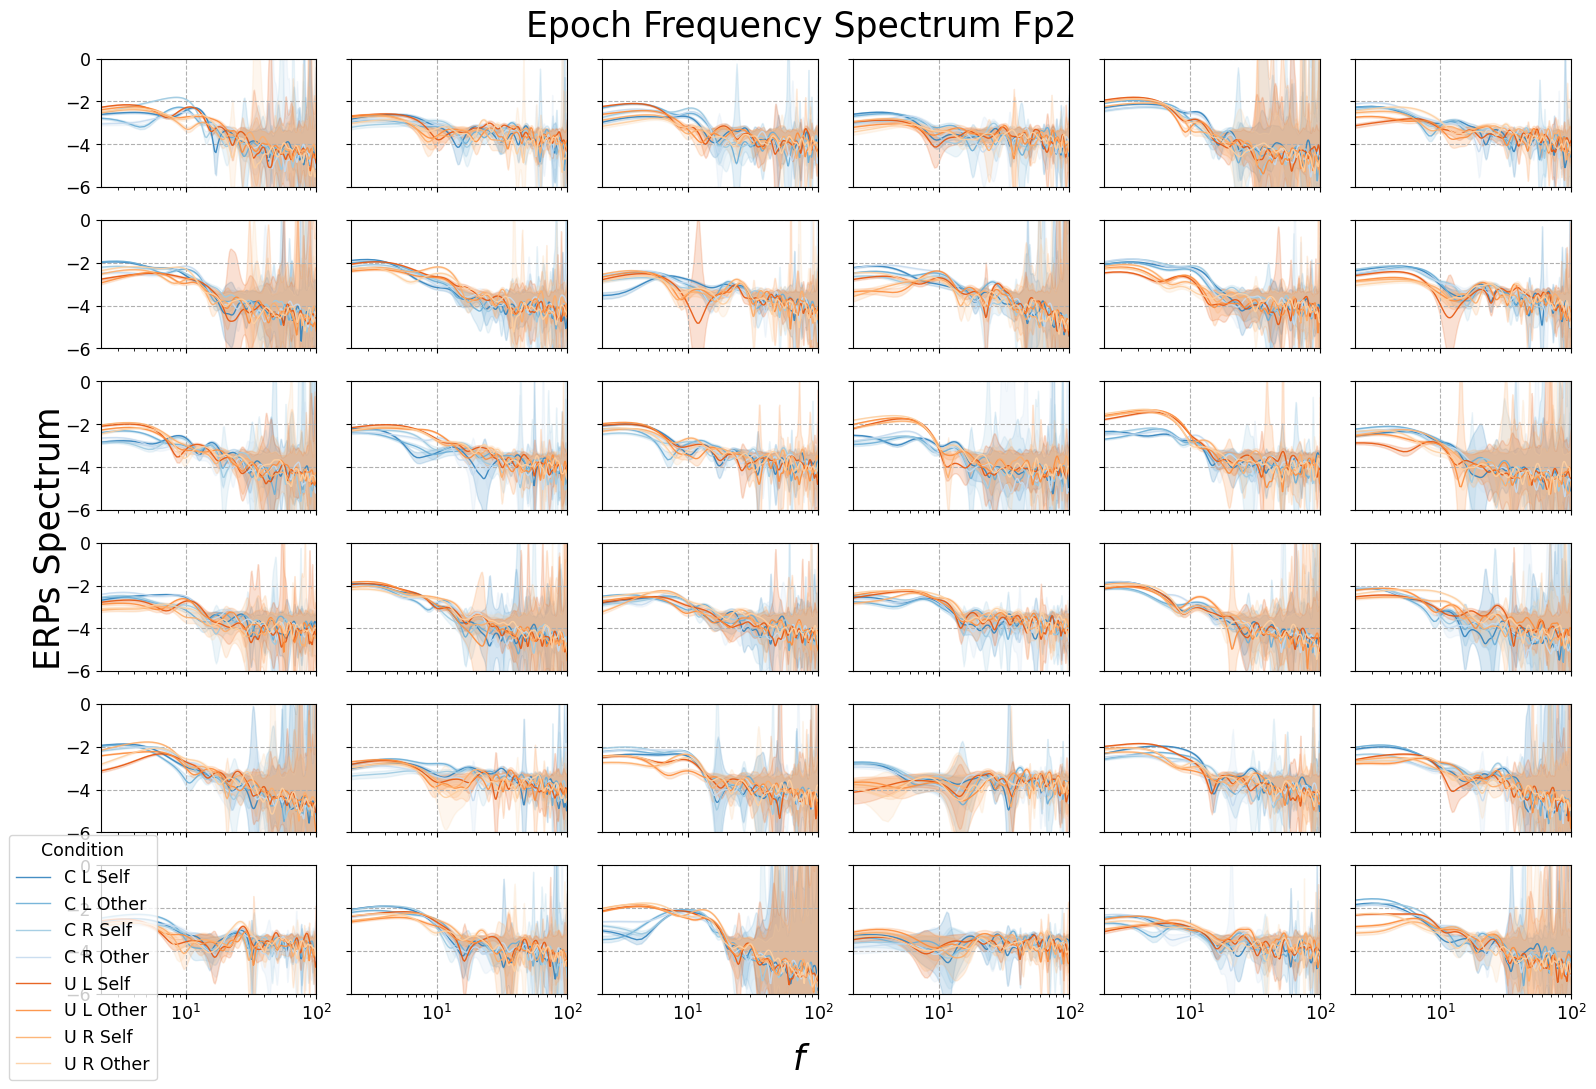

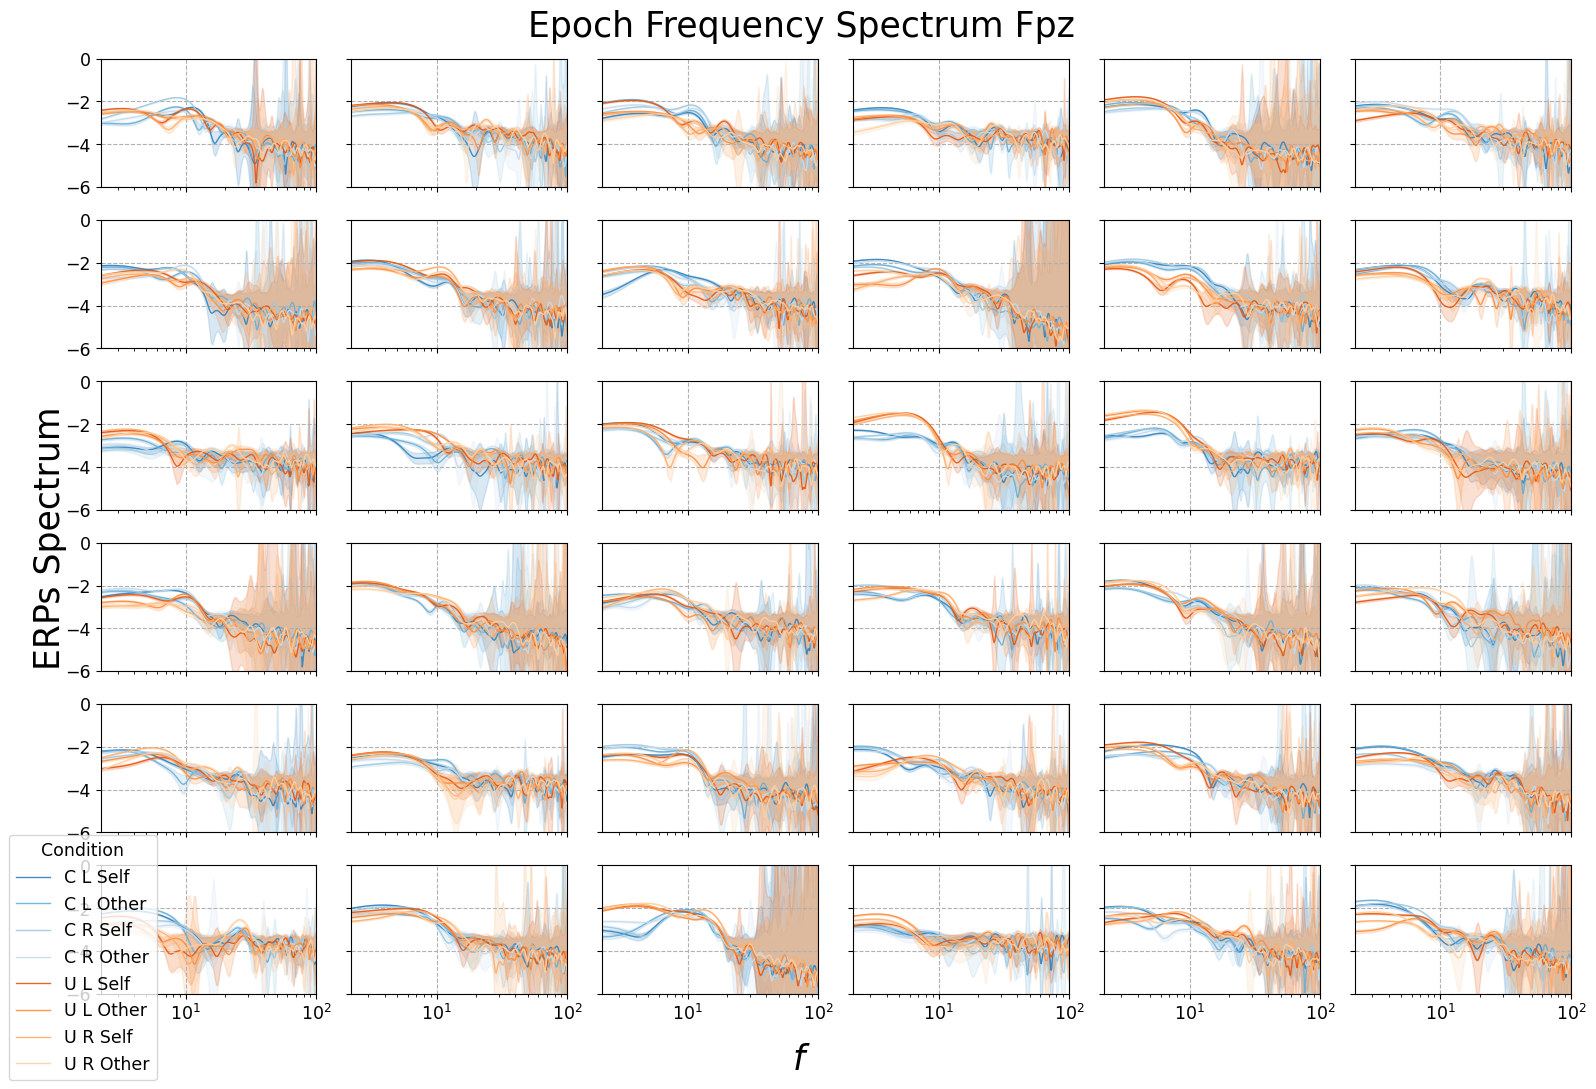

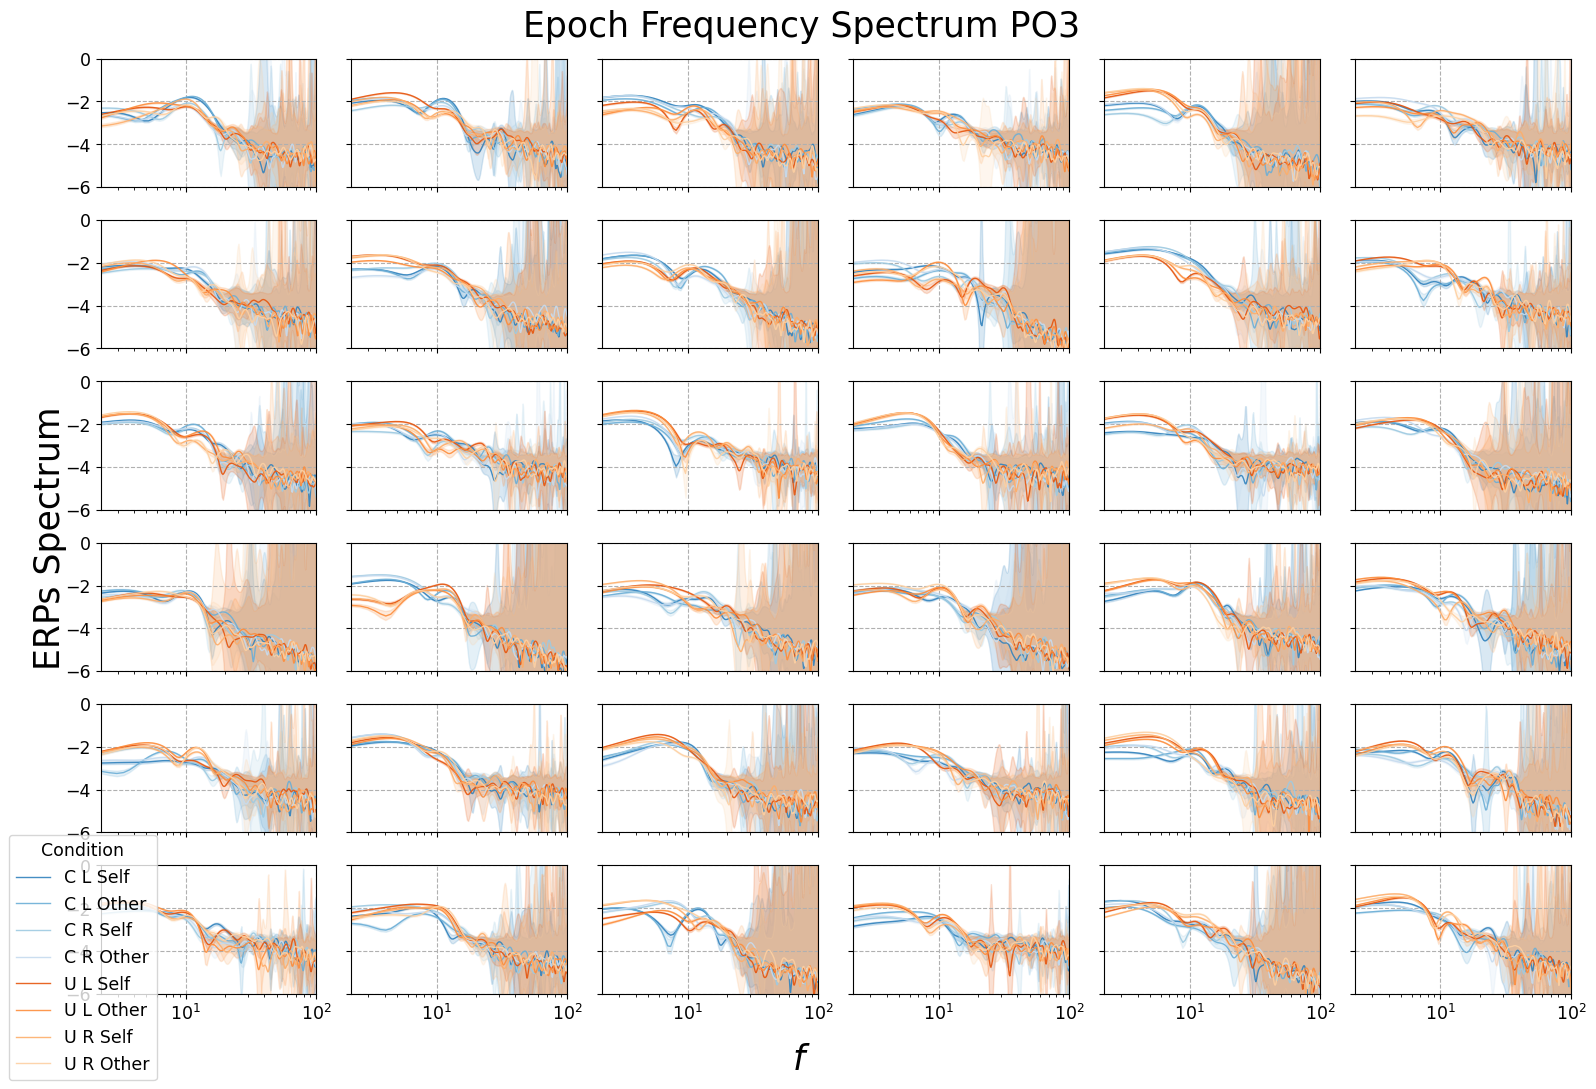

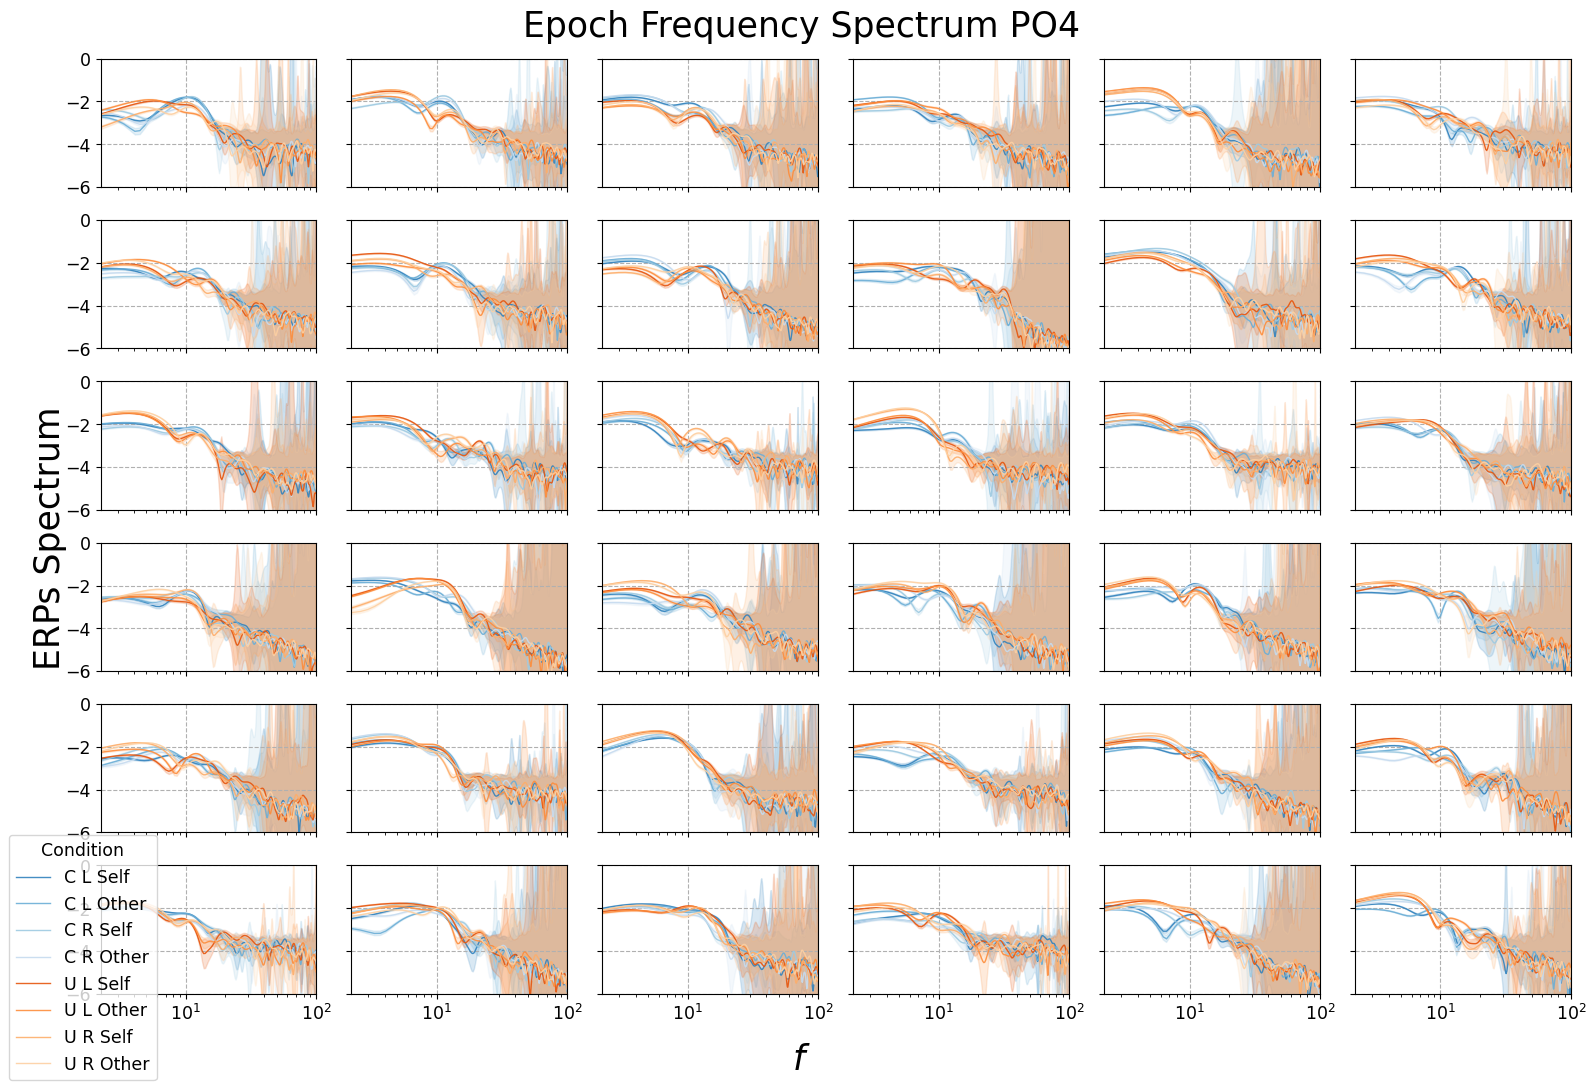

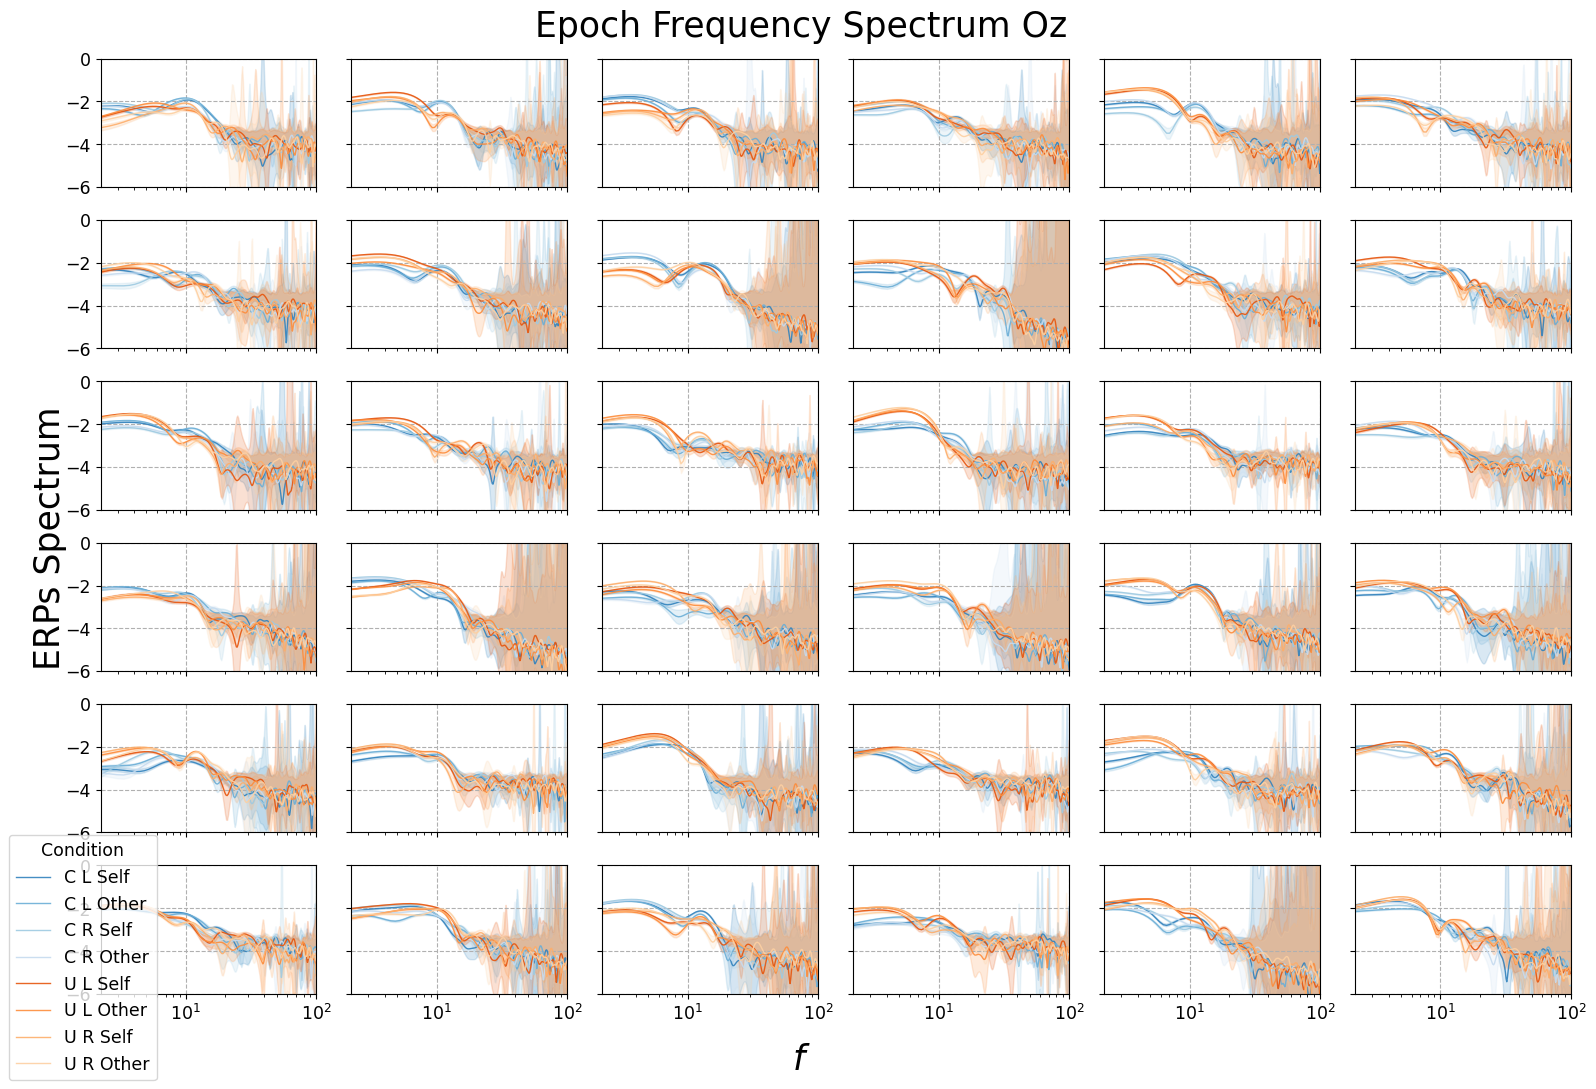

In [7]:
import matplotlib.cm as cm

# Print data with wrapper

# Info dictionary about observable
info = {
    'exp_name': 'zbmasking_dense',
    'avg_trials': True,
    'obs_name': 'spectrum',
    'clust_lb': 'CFPO',
    'calc_lb': 'FL',
}

# Extra instructions dictionary for standard instructions override
extra_instructions = {
    'reduce_legend': [2,3,4,5,6,7,8,9],
    #'avg': 'sub',
    #'dim_m': 1.2,
    #'grid': (1,1),
    'ylim': (-6, 0),
    #'legend_s': True
    'alpha_m': 0.9,
    'colormap': cm.tab20c,
    'linewidth': 1,
    #'ylabel': 'ERPs $[V]$'
    }

#extra_instructions = None

# Launch the wrapper
from plotting import simple_plot

simple_plot(info = info, extra_instructions = extra_instructions, show = True, save = True, verbose = True)

**Observables can also be compared on this layered graphics wrapper**

In [ ]:
# Print data with wrapper

# Info dictionary about observable
info_1 = {
    'exp_name': 'zbmasking_dense',
    'avg_trials': True,
    'obs_name': 'correxp',
    'clust_lb': 'CFPO',
    'calc_lb': '[[m_dense_MI]w_0]3nogauss',
}

info_2 = {
    'exp_name': info_1['exp_name'],
    'avg_trials': info_1['avg_trials'],
    'obs_name': 'correxp',
    'clust_lb': info_1['clust_lb'],
    'calc_lb': '[[m_dense_MI]w_80]3nogauss',
}

extra_instructions_1 = {
        'alpha_m': 0.2,
        'colormap': 'k',
        'linewidth': 0.5,
        'legend_s': False
}

extra_instructions_2 = {
    #'X_transform': 2,
    #'style': 'curve',
    'ylim': (0,10),
    #'xlim': (-5,2.5)
}

#extra_instructions_1 = None
#extra_instructions_2 = None

# Launch the wrapper
from plotting import double_plot
from multiprocessing import Pool

double_plot(info_1 = info_1, info_2 = info_2, extra_instructions_1 = extra_instructions_1, extra_instructions_2 = extra_instructions_2, show = True, save = False, verbose = True)

**Check Epoch files after preprocessing**

In [ ]:
import mne
import matplotlib.pyplot as plt

# Easily switch backend for MNE plotting
def ion():
    mne.viz.set_browser_backend('qt', verbose = True)
    return

def ioff():
    mne.viz.set_browser_backend('matplotlib', verbose = False)
    return

# Our Very Big Dictionary
from init import get_maind

maind = get_maind()

In [ ]:
# Data Infos
exp_name = 'bmasking_dense'

subID = '036'

condition = 'S__1'

picks = None #['Fp1','Fp2','Fpz']

# Get epoch file path

filepath = maind[exp_name]['directories']['data'] + subID + '/' + subID + condition + '-epo.fif'

epoch = mne.read_epochs(filepath)

evoked = epoch.average()
s_evoked = epoch.standard_error()

# Plot average over Trials and Standard Error
fig, axs = plt.subplots(1,2, figsize = (15,5), dpi = 300)

ioff()
evoked.plot(axes = axs[0], picks = picks, show = False)
s_evoked.plot(axes = axs[1], picks = picks, show = False)

fig.suptitle('Condition key: ' + condition)

axs[0].set_title('Average over trials')
axs[1].set_title('Standard Error over trials')

plt.show()

## Have fun with ICA

In [ ]:
from mne.preprocessing import ICA

ica = ICA(n_components = 20, random_state = 42, max_iter = 'auto')
ica.fit(epoch)

In [ ]:
import numpy as np

### Print Power spectrum of ICA decomposition ###
sources = ica.get_sources(epoch)

# Plot the power spectrum for each ICA component
n_components = ica.n_components_ 

# Loop through each ICA component
for i in range(n_components):
    # Extract the signal of component i
    component_data = sources.get_data(picks = [i])  # Get data for the i-th ICA component

    # Compute the power spectral density (PSD) of the component
    psd, freqs = mne.time_frequency.psd_array_welch(
        component_data[0],  # Extract the first row (since it's a single component)
        sfreq = 1000,  # Sampling frequency from the raw data
        fmin = 2, fmax = 100,  # Focus on the filter range
        n_fft = 900,  # Length of FFT (controls frequency resolution)
        verbose = False
    )

    # Plot the power spectrum of the component
    fig, ax = plt.subplots(1,2, figsize = (7,3), dpi = 100)
    ax[1].plot(freqs, 10*np.log10(psd).flatten(), label = f'Component {i}')
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('Power (dB)')
    ax[1].set_title(f'Power Spectrum of ICA Component {i}')
    ax[1].grid(True, linestyle = '--', alpha = 0.6)
    #ax[1].set_ylim(-35,-6)

    ica.plot_components(picks = i, show_names = True, axes = ax[0]);
    plt.show()

In [ ]:
ion()
ica.plot_sources(epoch, precompute = True);

In [ ]:
bad_ICA = sorted(ica.exclude)

# Apply ICA to copy of raw data
cleaned_epoch = epoch.copy()
ica.apply(cleaned_epoch)

In [ ]:
evoked = cleaned_epoch.average()
s_evoked = cleaned_epoch.standard_error()

# Plot average over Trials and Standard Error
fig, axs = plt.subplots(1,2, figsize = (15,5), dpi = 300)

ioff()
evoked.plot(axes = axs[0], picks = picks, show = False)
s_evoked.plot(axes = axs[1], picks = picks, show = False)

fig.suptitle('Condition key: ' + condition)

axs[0].set_title('Average over trials')
axs[1].set_title('Standard Error over trials')

plt.show()

*Following cells do not take advantage of MNE data structure*

***Integration will follow***

**Print 2-dim Time Embedding trajectories**

In [ ]:
###Set parameters

#Time delay
tau = 20

#Number of datapoints to ignore from start and end of signals
trim = 0

#Experiment conditions to pull from
conditions = ['S__','S_1']

#POIs (Put a function here at some point)
poi_idx = ch_clust_idx

#Initialize directory
os.makedirs('./pics/backward_masking/2dim_emb/', exist_ok = True)

###Multiprocessing

#Create iterable function
def Sub_2dimPics(subID):

    twodim_graphs(subID, tau = tau, trim = trim, conditions = conditions, channels_idx = poi_idx)

    return

#Set multiprocessing parameters
workers = 2
chk_size = int(len(sub_list)/workers) + 1

#Run calculations
if __name__ == '__main__':
    with Pool(workers) as p:
        p.map(Sub_2dimPics, sub_list, chk_size)
